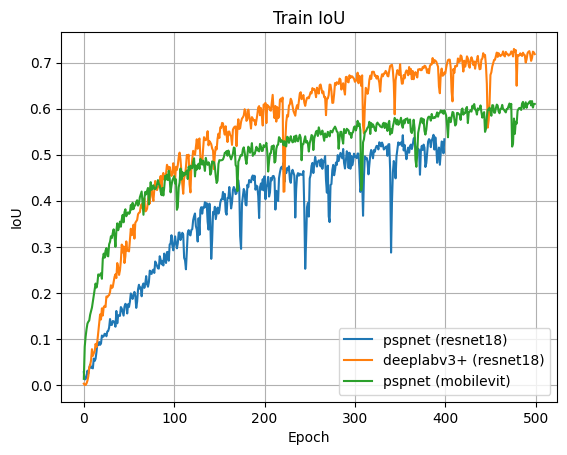

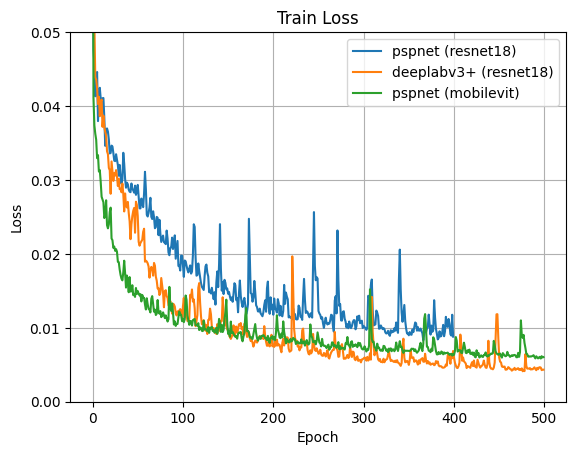

In [8]:
# Plot history
import pandas as pd
from matplotlib import pyplot as plt


def plot_ios(paths, labels):
    for path, label in zip(paths, labels):
        df = pd.read_csv(path)
        plt.plot(df.index, df.iou, label=label)
    plt.xlabel("Epoch")
    plt.ylabel("IoU")
    plt.title("Train IoU")
    plt.legend()
    plt.grid()
    plt.show()


def plot_loss(paths, labels):
    for path, label in zip(paths, labels):
        df = pd.read_csv(path)
        plt.plot(df.index, df.loss, label=label)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Train Loss")
    plt.ylim((0, 0.05))
    plt.legend()
    plt.grid()
    plt.show()


plot_ios(("histories\history_pspnet_r18_400.csv", 
          "histories\history_model_deeplab_r18_500.csv",
          "histories\history_model_pspnet_mobilevit__500.csv"),
          ("pspnet (resnet18)", "deeplabv3+ (resnet18)", "pspnet (mobilevit)"))

plot_loss(("histories\history_pspnet_r18_400.csv", 
          "histories\history_model_deeplab_r18_500.csv",
          "histories\history_model_pspnet_mobilevit__500.csv"),
          ("pspnet (resnet18)", "deeplabv3+ (resnet18)", "pspnet (mobilevit)"))

In [5]:
import model_loader


model = model_loader.SegmentationModel("pspnet", "tu-mobilevitv2_100", 3, True)
print(f"pspnet mobilevitv2_100: {sum([p.numel() for p in model.parameters()]) / 1e6}")
model = model_loader.SegmentationModel("deeplabv3plus", "tu-mobilevitv2_050", 3, True)
print(f"deeplabv3plus mobilevitv2_050: {sum([p.numel() for p in model.parameters()]) / 1e6}")

print()
model = model_loader.SegmentationModel("pspnet", "timm-mobilenetv3_small_100", 3, True)
print(f"pspnet mobilenetv3_small_100: {sum([p.numel() for p in model.parameters()]) / 1e6}")
model = model_loader.SegmentationModel("deeplabv3plus", "timm-mobilenetv3_small_100", 3, True)
print(f"deeplabv3plus mobilenetv3_small_100: {sum([p.numel() for p in model.parameters()]) / 1e6}")

pspnet mobilevitv2_100: 0.854118
deeplabv3plus mobilevitv2_050: 1.932269

pspnet mobilenetv3_small_100: 0.971374
deeplabv3plus mobilenetv3_small_100: 2.16162


In [2]:
import torch
from torch import nn
import numpy as np
from matplotlib import pyplot as plt
import model_loader
import os
from PIL import Image
from matplotlib.colors import ListedColormap
import tiles
from torch.utils.data import DataLoader
from dataset import CustomDataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
from utils import evaluate_model


MODEL_PATH = "checkpoints//best/model_BEST.pth"
MODEL_PSPNET_PATH = "checkpoints//best/model_pspnet_BEST.pth"


def display_images_in_row(images, figsize=(9, 3)):
    fig, axis = plt.subplots(1, len(images), figsize=figsize)
    for ax, img in zip(axis, images):
        ax.imshow(img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()


def read_images(dir_path, normalize=False):
    images = []
    for image_name in os.listdir(dir_path):
        img_path = os.path.join(dir_path, image_name)
        image = torch.Tensor(np.array((Image.open(img_path).convert("L")))).to("cuda")
        image = image.unsqueeze(0)
        images.append(image)
    return images


deeplab = model_loader.SegmentationModel("deeplabv3plus", "resnet18", 4, False)
deeplab.load_state_dict(torch.load(MODEL_PATH))
deeplab.to("cuda")
deeplab.eval()

pspnet = model_loader.SegmentationModel("pspnet", "resnet18", 4, False)
pspnet.load_state_dict(torch.load(MODEL_PSPNET_PATH))
pspnet.to("cuda")
pspnet.eval()

SegmentationModel(
  (model): PSPNet(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (b

In [3]:
images = read_images("cache//images")

In [14]:
deeplab_traced = torch.jit.trace(deeplab, images[0].unsqueeze(0))
deeplab_traced.save("deeplab_exported.torchscript")

c:\Users\Opina\AppData\Local\Programs\Python\Python311\Lib\site-packages\segmentation_models_pytorch\base\model.py:17: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if h % output_stride != 0 or w % output_stride != 0:
c:\Users\Opina\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1541: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return forward_call(*args, **kwargs)


In [15]:
pspnet_traced = torch.jit.trace(pspnet, images[0].unsqueeze(0))
pspnet_traced.save("pspnet_exported.torchscript")

In [16]:
deeplab = torch.load("deeplab_exported.torchscript")
deeplab.to("cuda")
deeplab.eval()

pspnet = torch.load("pspnet_exported.torchscript")
pspnet.to("cuda")
pspnet.eval()

c:\Users\Opina\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\serialization.py:1006: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn("'torch.load' received a zip file that looks like a TorchScript archive"


RecursiveScriptModule(
  original_name=SegmentationModel
  (model): RecursiveScriptModule(
    original_name=PSPNet
    (encoder): RecursiveScriptModule(
      original_name=ResNetEncoder
      (conv1): RecursiveScriptModule(original_name=Conv2d)
      (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
      (relu): RecursiveScriptModule(original_name=ReLU)
      (maxpool): RecursiveScriptModule(original_name=MaxPool2d)
      (layer1): RecursiveScriptModule(
        original_name=Sequential
        (0): RecursiveScriptModule(
          original_name=BasicBlock
          (conv1): RecursiveScriptModule(original_name=Conv2d)
          (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
          (relu): RecursiveScriptModule(original_name=ReLU)
          (conv2): RecursiveScriptModule(original_name=Conv2d)
          (bn2): RecursiveScriptModule(original_name=BatchNorm2d)
        )
        (1): RecursiveScriptModule(
          original_name=BasicBlock
          (conv1): RecursiveS

In [10]:
images = read_images("cache/images/")
masks = read_images("cache/labels/")
dataset = CustomDataset(image_dir="cache/images/", mask_dir="cache/labels/", transform=A.Compose([ToTensorV2()]))
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

"""precisions, recalls, ious, dices, avg_test_loss, avg_test_iou = evaluate_model(pspnet, dataloader, nn.CrossEntropyLoss(), "cuda", 4, 32)
print(f"Test IoU: {avg_test_iou:.4f}")
print(f"Metrics by class:")
print(f"    IoU:        {[round(x, 2) for x in ious[1:]]}")
print(f"    Dice (F1):  {[round(x, 2) for x in dices[1:]]}")
print(f"    Precision:  {[round(x, 2) for x in precisions[1:]]}")
print(f"    Recall:     {[round(x, 2) for x in recalls[1:]]}")"""

'precisions, recalls, ious, dices, avg_test_loss, avg_test_iou = evaluate_model(pspnet, dataloader, nn.CrossEntropyLoss(), "cuda", 4, 32)\nprint(f"Test IoU: {avg_test_iou:.4f}")\nprint(f"Metrics by class:")\nprint(f"    IoU:        {[round(x, 2) for x in ious[1:]]}")\nprint(f"    Dice (F1):  {[round(x, 2) for x in dices[1:]]}")\nprint(f"    Precision:  {[round(x, 2) for x in precisions[1:]]}")\nprint(f"    Recall:     {[round(x, 2) for x in recalls[1:]]}")'

In [18]:
n = 10
total_total_iou = 0
a = True
preds_deeplab = []
preds_pspnet = []
for image, mask in zip(images[:n], masks[:n]):
    mask = mask.long()
    output_deeplab = deeplab(image.unsqueeze(0))
    output_pspnet = pspnet(image.unsqueeze(0))
    pred_deeplab = torch.argmax(output_deeplab, axis=1)
    pred_pspnet = torch.argmax(output_pspnet, axis=1)

    preds_deeplab.append(pred_deeplab)
    preds_pspnet.append(pred_pspnet)

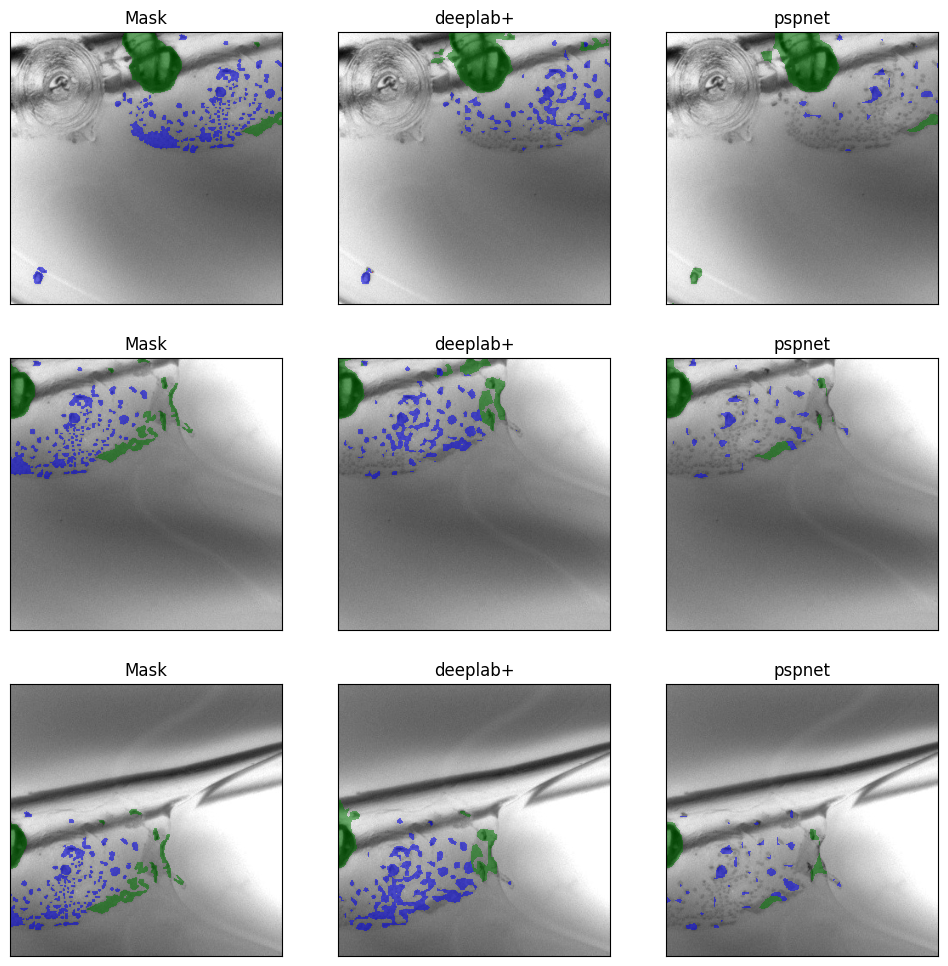

In [23]:
n = 3
#indices = np.random.choice(len(preds_deeplab), n)
indices = np.arange(5, 10, 1)
fig, axis = plt.subplots(n, 3, figsize=(12, 4*n))
a = True
for row, i in zip(axis, indices):
    for ax in row:
        ax.imshow(images[i].squeeze(0).cpu().detach(), alpha=1, cmap="gray")
        ax.set_xticks([])
        ax.set_yticks([])
    row[0].imshow(masks[i].squeeze(0).cpu().detach(), alpha=0.5, vmax=3, interpolation="nearest", cmap=ListedColormap(((0, 0, 0, 0), ("red"), ("green"), ("blue"))))  
    row[1].imshow(preds_deeplab[i].squeeze(0).cpu().detach(), alpha=0.5, vmax=3, interpolation="nearest", cmap=ListedColormap(((0, 0, 0, 0), ("red"), ("green"), ("blue"))))  
    row[2].imshow(preds_pspnet[i].squeeze(0).cpu().detach(), alpha=0.5, vmax=3, interpolation="nearest", cmap=ListedColormap(((0, 0, 0, 0), ("red"), ("green"), ("blue"))))
    if a:
        row[0].set_title("Mask")
        row[1].set_title("deeplab+")
        row[2].set_title("pspnet")
        #a = False

plt.show()